In [3]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Импортируем датасет CIFAR-10

In [5]:
train_dataset = datasets.CIFAR10(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_dataset = datasets.CIFAR10(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)



Files already downloaded and verified
Files already downloaded and verified


## Визуализируем данные

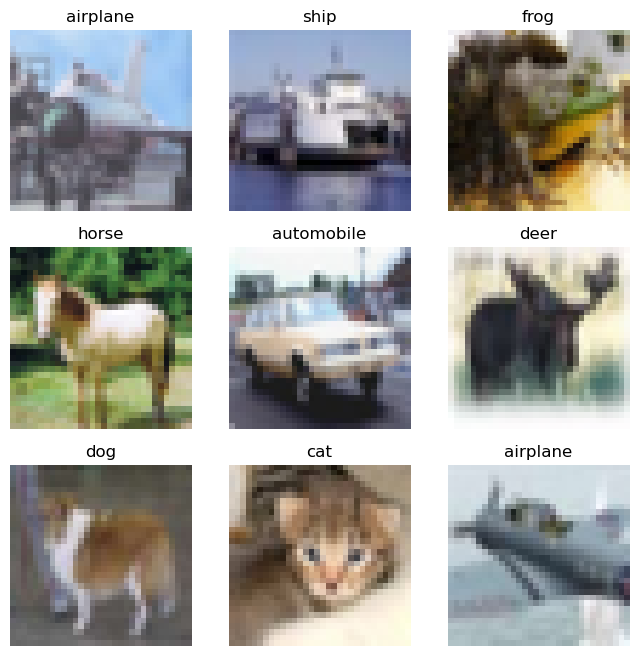

In [22]:
label_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(cols, rows, i)
    plt.title(label_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze().permute(1, 2, 0))
plt.show()

## Создаем DataLoaders

Feature batch size: torch.Size([64, 3, 32, 32])
Labels batch size: torch.Size([64])


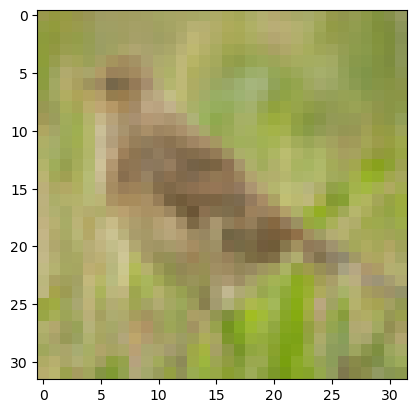

Label: bird


In [28]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# display random image with label
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch size: {train_features.size()}")
print(f"Labels batch size: {train_labels.size()}")
img = train_features[0].squeeze().permute(1, 2, 0)
label = train_labels[0].item()
plt.imshow(img)
plt.show()
print(f"Label: {label_map[label]}")

## Создаем модель

In [29]:
from torch import nn

In [34]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32 * 32, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


In [35]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Подготовка к обучению

#### Оценка точности

In [41]:
class AverageMeters(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.cnt = 0
        self.sum = 0
        self.val = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt

In [44]:
def accurasy(pred, target, topk=(1,)):
    batch_size = target.size(0)
    correct = (pred.argmax(1) == target).type(torch.float).sum().item()

    res = []
    res.append(correct * (100 / batch_size))

In [45]:
def train_loop(dataloader, model, criterion, optimizer):
    losses = AverageMeters()
    accs = AverageMeters()
    size = len(dataloader.dataset)
    model.train()

    for _, (data, target) in enumerate(dataloader):

        # compute output
        pred = model(data)
        loss = criterion(pred, target)

        # measure accurasy
        acc = accurasy(pred, target)

## Обучение

#### Инициализируем конфиги для обучения

In [36]:
config = {
    "batch_size": 64,
    "learning_rate": 1e-3,
    "total_epochs": 16
}

#### Инициализируем начальные состояния

In [37]:
random_seed = 42

#### Инициализируем остальные параметры

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = config["learning_rate"])